In [27]:
import pylab as pb
import numpy as np
from math import pi
from scipy.spatial.distance import cdist
from itertools import product
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from random import randint
from scipy.stats import norm
from numpy.linalg import inv
import random
import pandas as pd
import seaborn as sns

In [28]:
# To sample from a multivariate Gaussian
#f = np.random.multivariate_normal(mu,K);
# To compute a distance matrix between two sets of vectors
#D = cdist(x1,x2)
# To compute the exponetial of all elements in a matrix
#E = np.exp(D)

In [29]:
#Setting the priors parameters
W_prior = [-1.5, -0.5]
#cov_prior = np.diag([0.3,0.3])
#mu_prior = [0,0]
N = 100
sigma = 0.3
#sigmas = [0.1, 0.5, 0.7, 1.0, 2.0];
mu = 0
x = np.arange(-2,2.02,0.2)
np.random.shuffle(x)

In [30]:
ones = np.ones(len(x));
x_ones = lambda a : [a,1];
X = np.array([x_ones(value) for value in x])

In [62]:
def plot_distribution(N=1, mean = [0., 0.], covariance = [[1.,0],[0,1.]], prior_dist=True, counter = None):
    
    if prior_dist == True:
        distribution = 'prior'
    else: 
        distribution = 'posterior'
    N = 100
    w0 = np.linspace(-3.0, 3.0, N)
    w1 = np.linspace(-3.0, 3.0, N)
    
    w0, w1 = np.meshgrid(w0, w1)
    
    
     # Pack W0 and W1 into a single 3-dimensional array
    pos = np.empty(w0.shape + (2,))
    pos[:, :, 0] = w0
    pos[:, :, 1] = w1

    F = multivariate_normal(mean, covariance)
    Z = F.pdf(pos)
    
    
    plt.figure()
    plt.contourf(w0, w1, Z, cmap='jet')
    #im = plt.imshow(Z,cmap='inferno',extent=(-3, 3, -3, 3))
    plt.title(distribution + ' distribution over W')
    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.axis('scaled')
    
    plt.savefig(distribution + str(counter) + '.png')
    #plt.savefig('img/'+filename+"_2d.png", dpi=400);
    #print('...saving ' + filename)
    plt.show();
    """
    N, M = len(X), len(Y)
    Z = np.zeros((N, M))
    
    for i,(x,y) in enumerate(product(w0,w1)):
        pos = np.hstack((x, y))
        Z[np.unravel_index(i, (N,M))] =  multivariate_normal(mean, covariance).pdf(pos)
    
    im = plt.imshow(Z,cmap='inferno',extent=(-2, 2, -2, 2))
    ax = plt.gca()
    ax.grid(False)
    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.title(distribution + ' distribution over W')
    plt.show()
    """

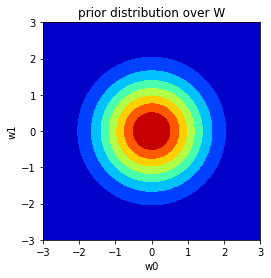

In [49]:
#Plotting the prior distribution over W
prior = plot_distribution()

In [33]:
#Generating data according to the paper
#For random samples from N(mu, sigma^2)
#Use sigma * np.random.randn(...) + mu
def gen_data(X, W, sigma, mu):
    
    #x = np.arange(-2,2.02,0.2)
    #x = np.random.choice(x)
    
    t = []
    
    sigma = np.sqrt(sigma)
    epsilon = sigma * np.random.randn() + mu

    for i in range(len(X)):
        t.append(W[0] * np.round(X[i][0]) + W[1] + epsilon)
    
    #t =W[0] * x + W[1] + epsilon
        
    #return x, t
    return np.array(t)

In [34]:
def generate_targets(W, X, sigma):
    t = [];
    sigmas = [0.1, 0.5, 0.7, 1.0, 2.0];
    for input in X:
        t.append((np.dot(input,W) + np.random.normal(0,np.random.choice(sigma))));
    return np.array(t);


In [35]:
t = gen_data(X, W_prior, sigma, mu)
#t = generate_targets(W_prior, X, sigma)

In [36]:
def computeLikelihood(amount, sigma, datapoint, target, posterior=None):
    
    w0 = np.linspace(-2, 2, num=amount)
    w1 = np.linspace(-2, 2, num=amount)
    
    X, Y = np.meshgrid(w0, w1)
    N, M = len(X), len(Y)
    Z = np.zeros((N, M))
   
    for i, (x,y) in enumerate(product(w0,w1)):
        pos = np.hstack((x,y))
        if posterior is None:
            Z[np.unravel_index(i, (N,M))] = norm(x*datapoint + y, np.sqrt(sigma)).pdf(target) * multivariate_normal([0, 0], [[sigma,0],[0,sigma]]).pdf(pos)
        else:   
            Z[np.unravel_index(i, (N,M))] = norm(x*datapoint + y, np.sqrt(sigma)).pdf(target) * posterior[i]
    
    #print(np.shape(Z))
    Z= np.reshape(Z,10000)
    indices = np.argsort(Z)[::-1][:20]
    Wsamples =[]
    for i,(x,y) in enumerate(product(w0,w1)):
        for j, index in enumerate(indices):
            if i == index :
                    Wsamples.append((x,y))
    
    return Z, Wsamples

In [37]:
def posterior(X=None, t=None, error_variance=None, Num_Samples=None, prio_cov=np.array([[ 1. , 0], [0,  1.]])):

    error_prior = prio_cov
    noise_variance = np.power(error_variance, 2.0)
    X = X[:Num_Samples]
    t = t[:Num_Samples]


    #Calculate posterior covariance
    X_trans = X.T;
    XTX = np.matmul(X_trans, X)
    posterior_covariance = inv(np.divide(XTX, noise_variance) + inv(error_prior))

    XTt = np.matmul(X_trans, t)

    #Calculate posterior mean using posterior covariance
    posterior_mean = np.divide((np.matmul(posterior_covariance, XTt)),noise_variance).flatten()


    return posterior_mean, posterior_covariance

In [38]:
def sample_from_dist(mean, cov):
    samples = np.random.multivariate_normal(mean, cov, 6);
    return samples;

In [39]:
#Z, Wsample = computeLikelihood(N, sigma, x, t2)
#mean, covariance = posterior(X, t, sigma, Num_Samples = 1)

In [40]:
#Drawing 6 samples from the posterior
#Wsamples = sample_from_dist(mean, covariance)

#Wsamples_six = random.sample(Wsample,6)

In [41]:
def plotSamples(X, W, N):
    #x = np.arange(-2.0, 2.2, 0.2)
    #y = np.arange(-1.0, 1.0, 0.1)
    X_print = []
    T = []
    X = X[:N]
    
    
    fig = plt.figure()
    #plt.ylim(-1.0, 1.0)
    ax = plt.gca()
    ax.grid(False)
    #for (w0,w1) in W:
    #    plt.plot(x,w0*x+w1)
    for (w0,w1) in W:
        for i in range(len(X)):
            t = w0*X[i][0]+w1
            x = X[i][0]
            T.append(t)
            X_print.append(X[i][0])
    #print(np.shape(X_print))
    #print(np.shape(T))
    
    
    plt.xlabel('x')
    plt.ylabel('t')
    plt.show()


In [71]:
def plot_functions(W_vector=None, X=None, input=None, num_samples=0, sigma=0.3, Counter = None):

    filename = "function_samples_"+str(num_samples)+"_sigma"+str(int(sigma*10));
    true_W = [-1.5, -0.5];
    T = [];
    counter = 1;
    for W in W_vector:
        for x in X:
            t = ((np.dot(x,W)));
            T.append({"t": t, "x": x[0], "Type":"sample", "Sample":counter});
        counter += 1;

    counter += 1;
    #for x in X:
    #    t = (np.dot(x,true_W));
    #    T.append({"t": t, "x": x[0], "Type":"origin", "Sample":counter})
    dataFrame = pd.DataFrame(T);
    sns.lineplot(x="x", y="t", hue="Sample", style="Type", legend=None, data=dataFrame, palette = ("Accent"))
    
    #plt.savefig('img/'+filename+"_.png", dpi=400);
    plt.savefig('function' + str(Counter) + '.png')
    with sns.color_palette("husl", 8):
        plt.show();
    #print('...saving function samples')
    #sns.lineplot(x="x", y="t", hue="Type", style="Type", legend=None, data=dataFrame)
    #plt.savefig('function' + str(counter) + '.png')
    #plt.show();
    #print('...saving function samples average')

In [43]:
#plotSamples2(Wsamples_six)
#plot_functions(Wsamples, X, x, 1, sigma)

In [44]:
def plotLikelihood(Z):
    Z= np.reshape(Z,(100,100))
    im = plt.imshow(Z,cmap='magma',extent=(-2, 2, -2, 2))
    plt.xlabel('w1')
    plt.ylabel('w0')
    ax = plt.gca()
    ax.grid(False)
    plt.show()

In [45]:
#plotLikelihood(Z)

In [46]:
#for i in range(5):
 #   x, t= gen_data(W_prior, sigma, mu)
  #  Z, W = computeLikelihood(100, sigma, x, t, Z)
   # Wsamp6 = random.sample(W,6)
    #plotSamples(Wsamp6)
    #plotLikelihood(Z)

#plotSamples(W)
#plotLikelihood(Z)

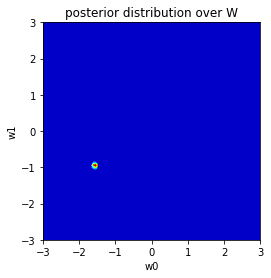

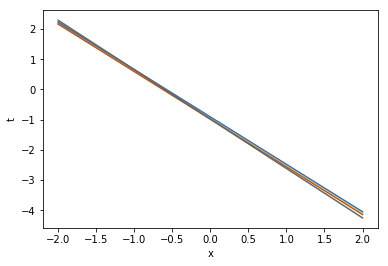

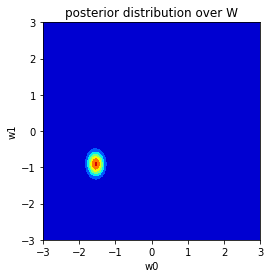

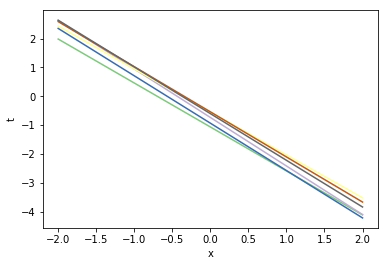

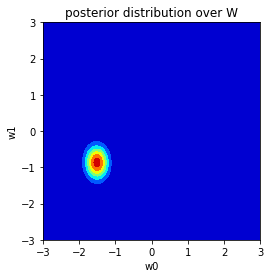

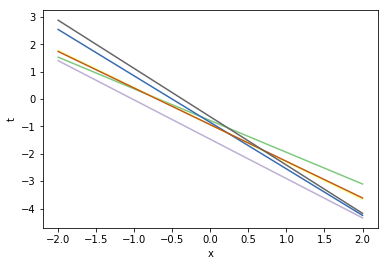

In [96]:
N = 0;
#t = gen_data(X, W_prior, sigma, mu)
#for i in range(0,5):
#    N = N + 1;
#    post_mu, post_cov = posterior(X=X,t=t, error_variance=sigma, Num_Samples=N);
#    #plot_distribution(N=N, mean = post_mu, covariance = post_cov, prior_dist=False, counter = N)
#    w_samples = sample_from_dist(post_mu, post_cov);
#    plot_functions(W_vector = w_samples, X = X, input = x, num_samples = N, Counter = N);

sigmas = [0.1, 0.5, 0.7]
N = 5
for _sigma in sigmas:
    #t = generate_targets(W_prior, X, _sigma);
    #t = t.reshape(len(t),1);
    posterior_mean, posterior_covariance = posterior(X=X,t=t, error_variance=_sigma, Num_Samples=N);
    plot_distribution(N = N, mean =posterior_mean, covariance=posterior_covariance, prior_dist=False, counter = _sigma);
    w_samples = sample_from_dist(posterior_mean, posterior_covariance);
    plot_functions(W_vector=w_samples, X=X, input=x, num_samples=N, sigma=_sigma, Counter= _sigma);


